In [1]:
from __future__ import print_function
import os
import numpy as np
from numpy import newaxis
from sklearn import preprocessing
np.random.seed(1337)

import keras
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Dropout
from keras.models import Model,Sequential
from keras.layers import Convolution1D, MaxPooling1D
import sys

import pandas as pd
import random

Using TensorFlow backend.


# Reading in data

In [2]:
print("Data read started...")
data = pd.read_csv("result9.csv")
data = data.as_matrix()
print ("Data read finished.")

touch_only = 'false'
touch_heart = 'false'
print(data.shape)

Data read started...
Data read finished.
(313, 15)


# Delete irrelevant data

In [3]:
data = np.delete(data, 13, 1)    
data = np.delete(data, 12, 1)  
data = np.delete(data, 11, 1)    
data = np.delete(data, 4, 1)     
data = np.delete(data, 3, 1)   
data = np.delete(data, 2, 1) 
data = np.delete(data, 1, 1)
data.shape

if(touch_only == 'true'):
    data = np.delete(data, 7, 1)    
    data = np.delete(data, 3, 1)    
    data = np.delete(data, 2, 1)     

if(touch_heart == 'true'):
    data = np.delete(data, 7, 1)     
    
data.shape

one = 0
two = 0
three = 0

for i in range(len(data)):
    if (data[i, 0] == 'NbackSym1'):
        one = one + 1
    if (data[i, 0] == 'NbackSym2'):
        two = two + 1
    if (data[i, 0] == 'NbackSym3'):
        three = three + 1

print(' one: ', one, ' two: ', two, ' three: ', three)

 one:  98  two:  104  three:  111


# Dictionary for the levels

In [4]:
level=["NbackSym1","NbackSym2","NbackSym3"]
level2int = dict((p, i) for i, p in enumerate(level))
int2level = dict((i, p) for i, p in enumerate(level))

# Z normalize

In [5]:
for i in range (1,data.shape[1]):
    data[:, i] = preprocessing.scale(data[:, i])

back1 = np.zeros((one,data.shape[1]-1))
back2 = np.zeros((two,data.shape[1]-1))
back3 = np.zeros((three,data.shape[1]-1))
j = 0
k = 0
l = 0

for i in range(len(data)):
    if (data[i, 0] == 'NbackSym1'):
        back1[j] = data[i, 1:]
        j = j+1
    if (data[i, 0] == 'NbackSym2'):
        back2[k] = data[i, 1:]
        k = k+1
    if (data[i, 0] == 'NbackSym3'):
        back3[l] = data[i, 1:]
        l = l+1

y_data = data[:, 0]
for i in range(len(data)):
    y_data[i] = level2int[y_data[i]]

/home/amoro/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/amoro/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/amoro/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/amoro/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/amoro/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConve

# One-hot encoding

In [6]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
one_hot = ohe.fit_transform(y_data.reshape(-1,1)).toarray()

# Group data for convolutional network

In [7]:
track = 20
null = np.array([0,0,0,0,0,0,0])

for i in range(track-1):
        back1 = np.vstack([back1, null])
        back2 = np.vstack([back2, null])
        back3 = np.vstack([back3, null])

x_data = np.zeros((data.shape[0],back1.shape[1],track))         # final input data for the network
y_one_hot = np.zeros((data.shape[0],one_hot.shape[1]))          # to store one-hot data groupped

for i in range(len(one_hot)):
    y_one_hot[i]=one_hot[i]

for i in range(len(back1)-track+1):
    for j in range(track-1):
        x_data[i, :, j] = back1[i+j]
        
index = 0
for i in range(len(back1)-track+1, len(back1)-track+1 + len(back2)-track+1):
    for j in range(track-1):
        x_data[i, :, j] = back2[index+j]
    index = index+1
    
index = 0
for i in range(len(back1)-track+1 + len(back2)-track+1, len(back1)-track+1 + len(back2)-track+1 + len(back3)-track+1):
    for j in range(track-1):
        x_data[i, :, j] = back3[index+j]
    index = index+1

# Shuffle data

In [8]:
indices = np.arange(x_data.shape[0])
np.random.shuffle(indices)

x_data = x_data[indices]
y_one_hot = y_one_hot[indices]

# Divide into train, validation and test data

In [9]:
len_data = len(x_data)

nb_test = int(len_data*0.15)
nb_validation = int(len_data*0.15)
nb_train = int(len_data*0.7)

end_valid = nb_train+nb_validation

x_train = x_data[0:nb_train]
y_train = y_one_hot[0:nb_train]

x_valid = x_data[nb_train:end_valid]
y_valid = y_one_hot[nb_train:end_valid]

x_test = x_data[end_valid:]
y_test = y_one_hot[end_valid:]

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)

(219, 7, 20) (219, 3) (46, 7, 20) (46, 3) (48, 7, 20) (48, 3)


# Build the net

In [10]:
model = Sequential()

model.add(Convolution1D(input_shape=(x_train[0].shape[-2],x_train[0].shape[-1]),
                        nb_filter=35,
                        filter_length=4,
                        border_mode='same',
                        subsample_length=2,
                        init='glorot_normal',
                        activation='relu')) 

model.add(Dropout(0.5))

model.add(Convolution1D(nb_filter=30,
                        filter_length=2,
                        border_mode='same',
                        subsample_length=2,
                        init='glorot_normal',
                        activation='relu'))

model.add(Dropout(0.25))


model.add(Flatten())

model.add(Dense(y_train.shape[1], activation='softmax'))

In [11]:
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])


model.fit(x_train, y_train, nb_epoch=200, shuffle=True, callbacks=[earlyStopping], 
          validation_data = (x_valid, y_valid), batch_size=50)

Train on 219 samples, validate on 46 samples
Epoch 1/200
219/219 [==============================] - 0s - loss: 1.0850 - acc: 0.3927 - val_loss: 1.0663 - val_acc: 0.6957
Epoch 2/200
219/219 [==============================] - 0s - loss: 1.0513 - acc: 0.6621 - val_loss: 1.0179 - val_acc: 0.7609
Epoch 3/200
219/219 [==============================] - 0s - loss: 0.9951 - acc: 0.7306 - val_loss: 0.9456 - val_acc: 0.7826
Epoch 4/200
219/219 [==============================] - 0s - loss: 0.9239 - acc: 0.7215 - val_loss: 0.8483 - val_acc: 0.7609
Epoch 5/200
219/219 [==============================] - 0s - loss: 0.8396 - acc: 0.8128 - val_loss: 0.7366 - val_acc: 0.7826
Epoch 6/200
219/219 [==============================] - 0s - loss: 0.7060 - acc: 0.8539 - val_loss: 0.6210 - val_acc: 0.8478
Epoch 7/200
219/219 [==============================] - 0s - loss: 0.6100 - acc: 0.8539 - val_loss: 0.5128 - val_acc: 0.8913
Epoch 8/200
219/219 [==============================] - 0s - loss: 0.5325 - acc: 0.8493 

In [12]:
model.evaluate(x_test, y_test, batch_size=50)

48/48 [==============================] - 0s


[0.0041245096363127232, 1.0]

In [13]:
from sklearn.metrics import classification_report,confusion_matrix

y_pred = model.predict_classes(x_test)
print(y_pred)

p=model.predict_proba(x_test)

target_names = ['class 0(0back)', 'class 1(1back)', 'class 2(2back)', 'class3(3back)']
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))
print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))

32/48 [===================>..........] - ETA: 0s[0 2 2 1 2 1 2 2 2 1 2 2 0 2 2 2 2 1 1 1 0 0 2 0 1 0 2 1 2 0 2 1 0 2 0 2 1
 1 0 2 0 0 0 2 1 2 1 1]
32/48 [===================>..........] - ETA: 0s                precision    recall  f1-score   support

class 0(0back)       1.00      1.00      1.00        13
class 1(1back)       1.00      1.00      1.00        14
class 2(2back)       1.00      1.00      1.00        21

   avg / total       1.00      1.00      1.00        48

[[13  0  0]
 [ 0 14  0]
 [ 0  0 21]]


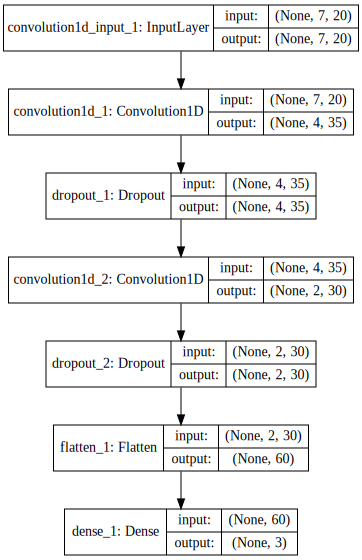

In [14]:
from IPython.display import Image, display, SVG
from keras.utils.visualize_util import model_to_dot

# Show the model in ipython notebook
figure = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
display(figure)

# Save the model as png file
from keras.utils.visualize_util import plot
plot(model, to_file='model_cnn.png', show_shapes=True)